Loaded 500 samples from ECG5000/ECG5000_TRAIN.ts
Loaded 4500 samples from ECG5000/ECG5000_TEST.ts
Shape of X_train: torch.Size([642, 139])
Shape of y_train: torch.Size([642])
Shape of X_test: torch.Size([4500, 139])
Shape of y_test: torch.Size([4500])
Shape of reduced train_dataset: 449
Shape of reduced val_dataset: 1125
Shape of reduced test_dataset: 1125


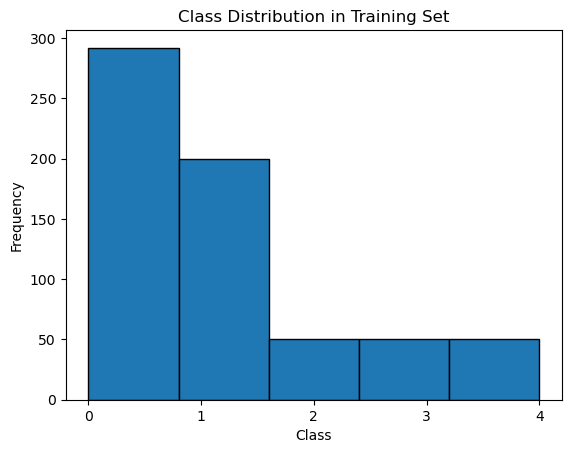

C:\Users\vmadhuu\AppData\Local\anaconda3\envs\tscproj\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/50], Loss: 1.4214, Training Accuracy: 52.78%
Validation Loss: 0.2751, Validation Accuracy: 100.00%
Test Loss: 0.2753, Test Accuracy: 100.00%
Epoch [2/50], Loss: 0.8861, Training Accuracy: 58.80%
Validation Loss: 0.6061, Validation Accuracy: 99.64%
Test Loss: 0.6075, Test Accuracy: 99.47%
Epoch [3/50], Loss: 0.6612, Training Accuracy: 59.02%
Validation Loss: 0.3737, Validation Accuracy: 99.91%
Test Loss: 0.3752, Test Accuracy: 100.00%
Epoch [4/50], Loss: 0.6648, Training Accuracy: 61.92%
Validation Loss: 0.3606, Validation Accuracy: 100.00%
Test Loss: 0.3617, Test Accuracy: 100.00%
Epoch [5/50], Loss: 0.6478, Training Accuracy: 62.14%
Validation Loss: 0.4725, Validation Accuracy: 99.82%
Test Loss: 0.4745, Test Accuracy: 100.00%
Epoch [6/50], Loss: 0.6551, Training Accuracy: 65.26%
Validation Loss: 0.4046, Validation Accuracy: 99.82%
Test Loss: 0.4066, Test Accuracy: 100.00%
Epoch [7/50], Loss: 0.6416, Training Accuracy: 64.14%
Validation Loss: 0.3674, Validation Accuracy: 99.82

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from imblearn.over_sampling import SMOTE
from mcCNN_utils import TimeSeriesImageDatasetMC

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to read UCR dataset
def read_ucr(filename):
    data = []
    labels = []
    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split(',')
            if len(parts) < 2:
                continue
            features = [float(f) for f in parts[:-1]]
            label = int(parts[-1].split(':')[-1])
            data.append(features)
            labels.append(label)
    print(f"Loaded {len(data)} samples from {filename}")
    return np.array(data), np.array(labels)


# File paths
train_file = 'ECG5000/ECG5000_TRAIN.ts'
test_file = 'ECG5000/ECG5000_TEST.ts'

# Load datasets
x_train, y_train = read_ucr(train_file)
x_test, y_test = read_ucr(test_file)

# Normalize labels to be within range [0, num_classes-1]
unique_labels = np.unique(y_train)
label_map = {label: idx for idx, label in enumerate(unique_labels)}
y_train = np.array([label_map[label] for label in y_train])
y_test = np.array([label_map[label] for label in y_test])

nb_classes = len(unique_labels)

# Normalize features
x_train_mean = x_train.mean()
x_train_std = x_train.std()
x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

# Apply SMOTE with custom sampling strategy to training data
desired_samples_per_class = {  
    1: 200,
    2: 50,
    3: 50,
    4: 50
}
smote = SMOTE(sampling_strategy=desired_samples_per_class, k_neighbors=1)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# Convert to PyTorch tensors
X_train = torch.tensor(x_train_resampled, dtype=torch.float32)
X_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train_resampled, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Gradually increasing size of training and testing sets 
train_size_reduced = int(0.7 * len(X_train))  # Use 70% of training data
test_size_reduced = int(0.5 * len(X_test))    # Use 50% of testing data

# Data Augmentation
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Create reduced training dataset
train_indices = list(range(train_size_reduced))
train_dataset_reduced = torch.utils.data.Subset(
    TimeSeriesImageDatasetMC(X_train.numpy(), y_train.numpy(), transform=transform, chart_type='bar'),
    train_indices
)

# Create reduced test dataset
test_indices = list(range(test_size_reduced))
test_dataset_reduced = torch.utils.data.Subset(
    TimeSeriesImageDatasetMC(X_test.numpy(), y_test.numpy(), transform=transform, chart_type='bar'),
    test_indices
)

# Split the reduced test data into validation and test sets
val_size = int(0.5 * len(test_dataset_reduced))
test_size = len(test_dataset_reduced) - val_size

val_dataset, test_dataset = random_split(test_dataset_reduced, [val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset_reduced, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print the shapes of the reduced datasets
print(f"Shape of reduced train_dataset: {len(train_dataset_reduced)}")
print(f"Shape of reduced val_dataset: {len(val_dataset)}")
print(f"Shape of reduced test_dataset: {len(test_dataset)}")


# Plot class distribution
plt.hist(y_train.numpy(), bins=nb_classes, edgecolor='k')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(ticks=np.arange(nb_classes))
plt.show()



class Simplified2DCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(Simplified2DCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Calculate the size of the flattened output
        self.flatten_size = self._get_flatten_size(input_channels)

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_size, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

    def _get_flatten_size(self, input_channels):
        dummy_input = torch.zeros(1, input_channels, 64, 64)
        x = self.conv_layers(dummy_input)
        return x.view(1, -1).size(1)




# Initialize the model, criterion, optimizer, and scheduler
model = Simple2DCNN(3, nb_classes).to(device)  
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)

# Training and evaluation loop
num_epochs = 50
best_test_accuracy = 0
patience = 10
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.2f}%')

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.inference_mode():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.inference_mode():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    scheduler.step(val_loss)

    if val_accuracy > best_test_accuracy:
        best_test_accuracy = val_accuracy
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

print(f'Best Test Accuracy: {best_test_accuracy:.2f}%')
